# Project_2_Recommenders_Using_Collaborative_Filtering_Post_Review3

## 1.1 Problem definition

   We feed user ratings of movies to a Collaborative Filter model which allows us to predict how users would rate other movies. Then pick one user, see how she rated movies (what movies she likes) and get predictions of movies she hasn't seen - which ones she would or wouldn't like and explain if that prediction makes sense.

   Error metrics are widely used for predictive accuracy. Root Mean Square Error(RMSE) evaluates the difference between the ratings predicted by the recommender and given by the users. We use “RMSE” as our accuracy metric for the predictions.

The above metric is well known in the field of data science and machine learning. But one thing to note is that the RMSE value of 0.931 for an algorithm doesn’t mean anything until there is another algorithm with another RMSE value with which we can compare our current RMSE value. The frame of reference we have is the average RMSE  for the 100k movie lens dataset as 0.9342. The advantage of using RMSE over MAE is that it penalizes the term more when the error is high. 

We use Surprise, which is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

## 2.1 Dataset

The user dataset comprises 100k ratings by 943 users on 1682 items. Each user has rated at least 20 movies.  Users and items are numbered consecutively from 1.  The data is randomly ordered. This is a tab-separated list of user id, item id, rating, and timestamp. 

The item dataset gives information about the items (movies). This is a tab-separated list of

movie id, movie title, release date, video release date, IMDb URL, unknown, Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western. The last 19 fields are the genres with 1 indicating the movie is of that genre and 0 it is not, movies can be in several genres at once. The movie ids are the ones used in the user data set.

Dataset Location: ~/.surprise_data/ml-100k/ml-100k/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, SVD
from surprise import BaselineOnly
from surprise import Reader
from surprise import accuracy
from surprise import Trainset
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict

## 2.2 Data Loading

In [2]:
columns_name=['user_id','item_id','rating','timestamp']
user=pd.read_csv('/Users/nizammohammad/.surprise_data/ml-100k/ml-100k/u.data',sep="\t",names=columns_name)        
#u.data is a tsv file (tab separated values)
print(user.head())
user.shape

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


(100000, 4)

In [3]:
movies_data=pd.read_csv('/Users/nizammohammad/.surprise_data/ml-100k/ml-100k/u.item',sep="\|",header= None)
movies_data.shape

<ipython-input-3-bee343609e4b>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies_data=pd.read_csv('/Users/nizammohammad/.surprise_data/ml-100k/ml-100k/u.item',sep="\|",header= None)


(1682, 24)

## 3.1 Exploratory Data Analysis

In [4]:
movies_data.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


There are 24 bitwise columns in movies_data

In [5]:
movies=movies_data
movies.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
movies.columns=['item_id', 'movie_title', 'release_date' , 'video_release_date',
              'IMDb_URL','unknown','Action','Adventure','Animation',
              'Childrens','Comedy','Crime','Documentary','Drama','Fantasy',
              'Film_Noir' ,'Horror' ,'Musical', 'Mystery', 'Romance' , 'Sci-Fi',
              'Thriller' , 'War' , 'Western'] 
movies.head(5)

,item_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
user.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


Check for missing values

In [9]:
user.isna().sum()

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

Merging user and movie dataframes

In [10]:
df=pd.merge(user,movies,on="item_id")

In [11]:
df.head()

,user_id,item_id,rating,timestamp,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,242,3,875747190,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
2,226,242,5,883888671,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
3,154,242,3,879138235,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0
4,306,242,5,876503793,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df.isna().sum()

user_id                    0
item_id                    0
rating                     0
timestamp                  0
movie_title                0
release_date               9
video_release_date    100000
IMDb_URL                  13
unknown                    0
Action                     0
Adventure                  0
Animation                  0
Childrens                  0
Comedy                     0
Crime                      0
Documentary                0
Drama                      0
Fantasy                    0
Film_Noir                  0
Horror                     0
Musical                    0
Mystery                    0
Romance                    0
Sci-Fi                     0
Thriller                   0
War                        0
Western                    0
dtype: int64

## 4.1 Machine Learning

### 4.1.1 Hyperparameter tuning

The matrix factorization algorithm(SVD) work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices.The minimization is performed by a very straightforward stochastic gradient descent:

In [13]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [14]:
# Load the movielens-100k dataset (download it if needed),
data = Dataset.load_builtin('ml-100k')

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

In [15]:
param_grid = {'n_epochs': [5, 10, 20], 'lr_all': [0.002, 0.005],
              'reg_all': [0.02, 0.04, 0.06]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9310786044881633
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.04}


### 4.1.2 Model Train

In [16]:
# We can now use the algorithm that yields the best rmse:
algo = gs.best_estimator['rmse']
# algo.fit(trainset)
algo.fit(data.build_full_trainset())

In [17]:
gs.best_estimator['rmse']

### 4.1.3 Predict

In [18]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [19]:
def get_predictions_for_each_user(predictions):
    """Return the recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    return top_n

In [20]:
# predict ratings for all pairs (u, i) that are NOT in the training set.
predictions = algo.test(trainset.build_anti_testset())

top_n = get_top_n(predictions, n=10)

In [21]:
print("UserId  List of top 10 movie recommendations and expected rating \n")

for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])
      print(uid,"\t", [(iid,_) for (iid, _) in user_ratings],"\n")

UserId  List of top 10 movie recommendations and expected rating 

267 	 [('127', 4.958690552118422), ('187', 4.860308561492223), ('180', 4.853742215761808), ('603', 4.8507185911158635), ('357', 4.826807780273931), ('134', 4.821965545585602), ('302', 4.821738203396069), ('513', 4.817604355912436), ('178', 4.817381342435831), ('272', 4.7966727719005835)] 

624 	 [('408', 4.654843494781638), ('318', 4.649316353442459), ('114', 4.598486360506278), ('169', 4.572670959689046), ('64', 4.567871011317076), ('923', 4.561575894898873), ('483', 4.557235947969686), ('187', 4.539056436860015), ('134', 4.5347029902642335), ('223', 4.534497621946184)] 

873 	 [('408', 4.1746849801447485), ('318', 4.110609441833753), ('496', 4.071218137650361), ('169', 4.057309054189504), ('136', 4.0396602454847566), ('316', 4.027761048526311), ('513', 4.018103089008121), ('480', 4.005503217931543), ('923', 4.0049498893258795), ('657', 3.9833017250807314)] 

752 	 [('114', 4.488063123351831), ('169', 4.484580139726859

## 5.1 Results

List of top 10 movie recommendation with corresponding rating for userId==196

In [22]:
# USER_ID=793
USER_ID=511

In [23]:
print("UserId ItemId  List of top 10 movie recommendation with corresponding rating\n")

for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])
    if int(uid) == USER_ID:
        for (iid, _) in user_ratings:
            
            df_test3= df[df['item_id'] == int(iid)]
        
            print(uid,"\t",iid,"\t", df_test3['movie_title'].iloc[0] ,"\t\t",_,"\n")

UserId ItemId  List of top 10 movie recommendation with corresponding rating

511 	 408 	 Close Shave, A (1995) 		 5 

511 	 169 	 Wrong Trousers, The (1993) 		 4.987241086910791 

511 	 318 	 Schindler's List (1993) 		 4.9311240443583175 

511 	 114 	 Wallace & Gromit: The Best of Aardman Animation (1996) 		 4.9243569114580055 

511 	 64 	 Shawshank Redemption, The (1994) 		 4.841643730679622 

511 	 963 	 Some Folks Call It a Sling Blade (1993) 		 4.820616466542634 

511 	 98 	 Silence of the Lambs, The (1991) 		 4.819170398609459 

511 	 483 	 Casablanca (1942) 		 4.810471027055689 

511 	 357 	 One Flew Over the Cuckoo's Nest (1975) 		 4.800756375053632 

511 	 127 	 Godfather, The (1972) 		 4.792903879016408 



In [24]:
for uid, user_ratings in top_n.items():
     if int(uid)==USER_ID:
        print(uid, [iid for (iid, _) in user_ratings])

511 ['408', '169', '318', '114', '64', '963', '98', '483', '357', '127']


## 6.1 Discussion

### 6.1.1 Validating the recommendation generated

In [25]:
ITEM_ID=318
# ITEM_ID=12

In [26]:
df_test1 = df[df['item_id'] == ITEM_ID]
df_test1.head(1)

,user_id,item_id,rating,timestamp,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
31134,200,318,5,884128458,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0


In [27]:
df_test1.head()

,user_id,item_id,rating,timestamp,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
31134,200,318,5,884128458,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0
31135,234,318,4,892078890,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0
31136,207,318,5,877124871,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0
31137,161,318,3,891170824,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0
31138,125,318,5,879454309,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0


In [28]:
df.loc[df['user_id'] == USER_ID,'Drama'].sum()

8

In [29]:
#Understanding the interests of User 198
df.dtypes

user_id                 int64
item_id                 int64
rating                  int64
timestamp               int64
movie_title            object
release_date           object
video_release_date    float64
IMDb_URL               object
unknown                 int64
Action                  int64
Adventure               int64
Animation               int64
Childrens               int64
Comedy                  int64
Crime                   int64
Documentary             int64
Drama                   int64
Fantasy                 int64
Film_Noir               int64
Horror                  int64
Musical                 int64
Mystery                 int64
Romance                 int64
Sci-Fi                  int64
Thriller                int64
War                     int64
Western                 int64
dtype: object

In [30]:
genre=['unknown','Action','Adventure','Animation','Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

In [31]:
df_test2=df.loc[df['user_id'] == USER_ID]

In [32]:
df_test2.shape

(24, 27)

In [33]:
df_test2.head

<bound method NDFrame.head of        user_id  item_id  rating  timestamp  \
538        511      346       4  890004686   
7973       511      322       3  890005102   
10061      511      288       4  890004795   
15239      511      294       4  890005011   
34507      511      872       5  890004728   
38252      511      343       3  890004892   
40229      511      271       5  890004879   
40940      511      678       2  890005076   
41640      511      333       4  890004778   
57740      511      292       5  890004686   
61142      511      948       3  890004916   
71959      511      299       2  890004827   
72612      511      682       4  890004844   
73475      511      355       2  890004827   
75447      511      908       4  890004938   
76475      511      300       4  890004658   
80602      511      313       5  890004702   
82626      511      340       4  890004687   
85212      511      260       4  890004916   
86599      511      880       5  890004778   
8838

In [34]:
genre_5_star={}
genre_4_star={}
df_test3=df_test2
for i in genre:
    genre_5_star[i]=df_test3.loc[df_test3['rating'] == 5,i].sum()
    genre_4_star[i]=df_test3.loc[df_test3['rating'] == 4,i].sum()

In [35]:
# preferences_for_gievn_user = dict(sorted(preferences_for_gievn_user.items(), key=lambda item: item[1],reverse=True))
print(genre_5_star)
print(genre_4_star)

{'unknown': 0, 'Action': 2, 'Adventure': 1, 'Animation': 0, 'Childrens': 0, 'Comedy': 0, 'Crime': 0, 'Documentary': 0, 'Drama': 4, 'Fantasy': 0, 'Film_Noir': 0, 'Horror': 0, 'Musical': 0, 'Mystery': 0, 'Romance': 2, 'Sci-Fi': 1, 'Thriller': 0, 'War': 1, 'Western': 0}
{'unknown': 0, 'Action': 2, 'Adventure': 0, 'Animation': 0, 'Childrens': 0, 'Comedy': 3, 'Crime': 1, 'Documentary': 0, 'Drama': 2, 'Fantasy': 0, 'Film_Noir': 0, 'Horror': 3, 'Musical': 0, 'Mystery': 3, 'Romance': 0, 'Sci-Fi': 1, 'Thriller': 6, 'War': 0, 'Western': 0}


## 6.1.1 Drawing inference from Graphs

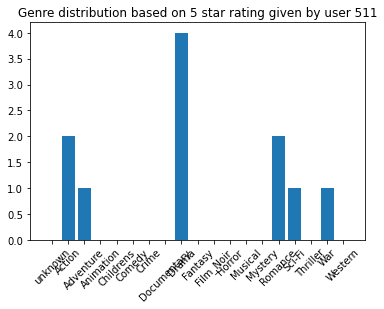

In [36]:
plt.bar(range(len(genre_5_star)), list(genre_5_star.values()), align='center')
plt.xticks(range(len(genre_5_star)), list(genre_5_star.keys()))
plt.xticks(rotation = 45) 

plt.title(f'Genre distribution based on 5 star rating given by user {USER_ID}')
plt.rcParams["figure.figsize"] = (10,5)

plt.show()

Figure 1.1

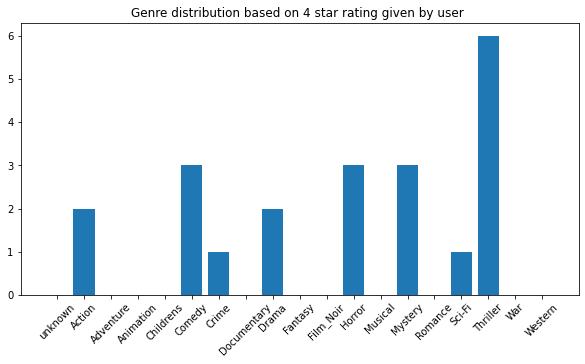

In [37]:
plt.bar(range(len(genre_4_star)), list(genre_4_star.values()), align='center')
plt.xticks(range(len(genre_4_star)), list(genre_4_star.keys()))
plt.xticks(rotation = 45) 

plt.title(f'Genre distribution based on 4 star rating given by user ')
plt.rcParams["figure.figsize"] = (10,5)

plt.show()

Figure 1.2

In [38]:
print("User Id Movie Id \t Movie Title \t\t Predicted rating from user \n")

for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])
    for (iid, _) in user_ratings:
#         print(iid)
        df_test3= df[df['item_id'] == int(iid)]
        if int(uid) == USER_ID:        
            print(uid,"\t",iid,"\t", df_test3['movie_title'].iloc[0] ,"\t\t",_,"\n")

User Id Movie Id 	 Movie Title 		 Predicted rating from user 

511 	 408 	 Close Shave, A (1995) 		 5 

511 	 169 	 Wrong Trousers, The (1993) 		 4.987241086910791 

511 	 318 	 Schindler's List (1993) 		 4.9311240443583175 

511 	 114 	 Wallace & Gromit: The Best of Aardman Animation (1996) 		 4.9243569114580055 

511 	 64 	 Shawshank Redemption, The (1994) 		 4.841643730679622 

511 	 963 	 Some Folks Call It a Sling Blade (1993) 		 4.820616466542634 

511 	 98 	 Silence of the Lambs, The (1991) 		 4.819170398609459 

511 	 483 	 Casablanca (1942) 		 4.810471027055689 

511 	 357 	 One Flew Over the Cuckoo's Nest (1975) 		 4.800756375053632 

511 	 127 	 Godfather, The (1972) 		 4.792903879016408 



In [39]:
df[df['item_id'] == ITEM_ID]

,user_id,item_id,rating,timestamp,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
31134,200,318,5,884128458,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0
31135,234,318,4,892078890,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0
31136,207,318,5,877124871,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0
31137,161,318,3,891170824,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0
31138,125,318,5,879454309,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31427,908,318,5,879722717,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0
31428,846,318,5,883947777,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0
31429,524,318,4,884635287,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0
31430,913,318,4,880794731,Schindler's List (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Schindler's%2...,0,0,...,0,0,0,0,0,0,0,0,1,0


In [40]:
movie_type={}
for i in genre:
    movie_type[i]=df.loc[df['item_id'] == ITEM_ID,i].sum()

In [41]:
print(movie_type)

{'unknown': 0, 'Action': 0, 'Adventure': 0, 'Animation': 0, 'Childrens': 0, 'Comedy': 0, 'Crime': 0, 'Documentary': 0, 'Drama': 298, 'Fantasy': 0, 'Film_Noir': 0, 'Horror': 0, 'Musical': 0, 'Mystery': 0, 'Romance': 0, 'Sci-Fi': 0, 'Thriller': 0, 'War': 298, 'Western': 0}


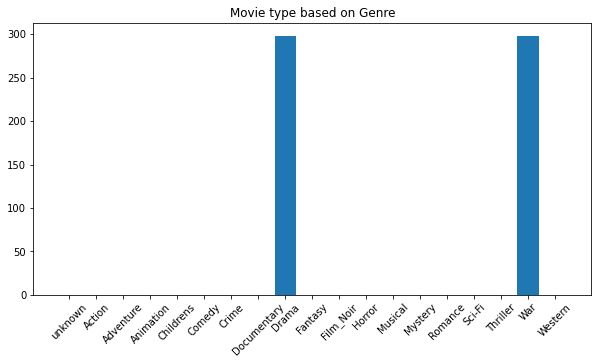

In [42]:
plt.bar(range(len(movie_type)), list(movie_type.values()), align='center')
plt.xticks(range(len(movie_type)), list(movie_type.keys()))
plt.xticks(rotation = 45) 

plt.title('Movie type based on Genre')
plt.rcParams["figure.figsize"] = (5,5)

plt.show()

Figure 1.3

## Post Review changes

Review points:
    Consider average rating rather than cummulative sum per genre and
    Plot Histogram with movie distribution across each category

In [43]:
genre_star_avg={}
genre_star_count={}
df_test3=df_test2
j=0
for i in genre:
    df_test4 = df_test3[df_test3[i] != 0 ]
    df_test5 = df_test4[df_test4['rating'] > 3]
    genre_star_avg[i] = df_test5['rating'].mean()
    genre_star_count[i] = df_test5.shape[0]

In [44]:
print(genre_star_avg)

{'unknown': nan, 'Action': 4.5, 'Adventure': 5.0, 'Animation': nan, 'Childrens': nan, 'Comedy': 4.0, 'Crime': 4.0, 'Documentary': nan, 'Drama': 4.666666666666667, 'Fantasy': nan, 'Film_Noir': nan, 'Horror': 4.0, 'Musical': nan, 'Mystery': 4.0, 'Romance': 5.0, 'Sci-Fi': 4.5, 'Thriller': 4.0, 'War': 5.0, 'Western': nan}


## Drawing inference from Graphs

In [45]:
import matplotlib.pyplot as plt
import numpy as np

In [46]:
genre_star_avg.values()

dict_values([nan, 4.5, 5.0, nan, nan, 4.0, 4.0, nan, 4.666666666666667, nan, nan, 4.0, nan, 4.0, 5.0, 4.5, 4.0, 5.0, nan])

In [47]:
genre_={}
df_=df_test2
for i in genre:
    df_test4 = df_[df_[i] != 0 ]
    df_test5 = df_test4['rating']
    genre_[i] = df_test5
#     genre_drama[i] = df_test5['rating'].mean()

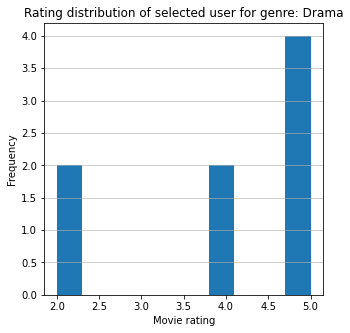

In [48]:
i='Drama'
plt.hist(genre_[i])


plt.title('Rating distribution of selected user for genre: ' + str(i))
plt.xlabel('Movie rating')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
  
# Showing the plot using plt.show()
plt.show()

<BarContainer object of 19 artists>

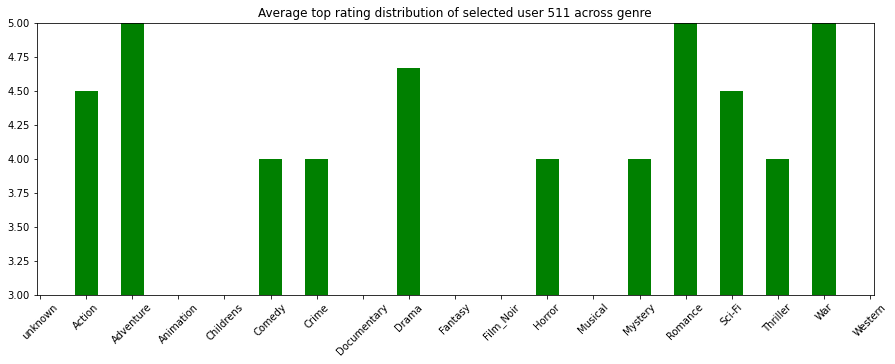

In [49]:
mylist = [key for key, val in genre_star_avg.items()]
myvalues= [val for key, val in genre_star_avg.items()]
plt.figure(figsize=(15,5))
plt.ylim([3, 5])
plt.xticks(rotation = 45) 
plt.title('Average top rating distribution of selected user ' + str(USER_ID) + ' across genre')
plt.bar(mylist,myvalues,width=.5, color='g')

## POST REVIEW #3
Replace mean of top movie ratings with the frequency distribution rated by user:511 across multiple genre

In [50]:
print(genre_star_count)

{'unknown': 0, 'Action': 4, 'Adventure': 1, 'Animation': 0, 'Childrens': 0, 'Comedy': 3, 'Crime': 1, 'Documentary': 0, 'Drama': 6, 'Fantasy': 0, 'Film_Noir': 0, 'Horror': 3, 'Musical': 0, 'Mystery': 3, 'Romance': 2, 'Sci-Fi': 2, 'Thriller': 6, 'War': 1, 'Western': 0}


<BarContainer object of 19 artists>

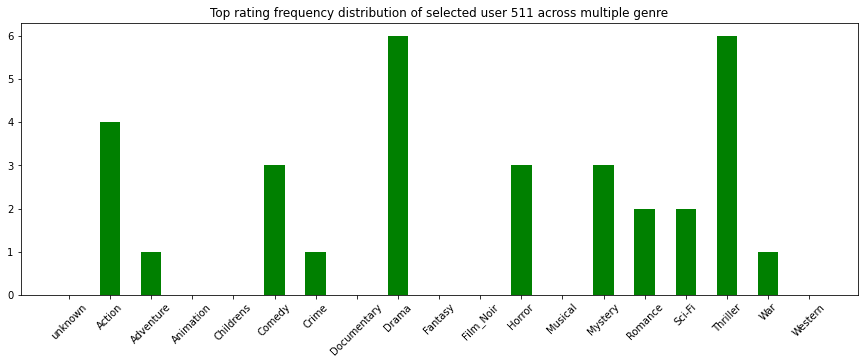

In [51]:
mylist = [key for key, val in genre_star_count.items()]
myvalues= [val for key, val in genre_star_count.items()]
plt.figure(figsize=(15,5))
plt.xticks(rotation = 45) 
plt.title('Top rating frequency distribution of selected user ' + str(USER_ID) + ' across multiple genre')
plt.bar(mylist,myvalues,width=.5, color='g')

                  Figure 1.4

## Summary

In this project, we retrieve the top-10 items with the highest rating prediction for each user in the MovieLens-100k dataset. We first train an SVD algorithm on the whole dataset and then predict all the ratings for the pairs (user, item) that are not in the training set. We then retrieve the top-10 prediction for each user.

And as Collaborative filtering leverages the power of the crowd. The intuition behind collaborative filtering is that if user A likes movies X and Y, and if another user B likes movie X, there is a fair bit of chance that he will like the movie Y as well.

Suppose a huge number of users have assigned the same ratings to movies X and Y. A new user comes who has assigned the same rating to movie X but hasn't watched movie Y yet. The collaborative filtering system will recommend the movie Y.


Justification of generated prediction: 

   The initial approach is based on the cumulative sum of top ratings(5&4 star) based on genre and Figures 1.1 and 1.2 depict the top movie rating distribution of users (user_id:511) across genres with user's interest in Thriller, action & Drama. The top recommendation generated by the model for the user(511) is Schindler's List (1993) which falls under Drama, War genre as evident from Figure 1.3 & Figure 1.4 . Thereby implying a good recommendation covering user interest to some extent and also following a structured pattern of similar users who already watched the movie


   Post-review modifications include the consideration of top rating frequency distribution as a measure rather than the average of top ratings. The same distribution is shown in histogram Figure 1.4 where X-axis depicts the genre-based top rating frequency distribution.

## Environment setup

### References:
https://surprise.readthedocs.io/en/stable/index.html

https://medium.com/analytics-vidhya/recommender-systems-explicit-feedback-implicit-feedback-and-hybrid-feedback-ddd1b2cdb3b

https://surprise.readthedocs.io/en/stable/matrix_factorization.html

https://surprise.readthedocs.io/en/stable/FAQ.html

https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/

https://www.jiristodulka.com/post/recsys_cf/

##  THE END